In [3]:
import random as rd
import numpy as np
from itertools import product
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]
#Changes to these correlations over 61 days
change = []
k_0 = 0.003
for i in range (0, 61):
    change.append(np.sin(k_0*i))    

In [4]:
sigma = 0.6
#Correlation matrix of 100 stocks based on their sector structure
daily_corr = np.zeros((61, 100, 100))
for (i, j) in product (range(0,100), range(0,100)):
    for k in range(0, 61):
        if (i>j):
            daily_corr[k][i][j] = np.tanh(np.random.normal(M2_S[i/10, j/10]+change[k], sigma, 1))
            daily_corr[k][j][i] = daily_corr[k][i][j]
        else:
            if (i==j):
                daily_corr[k][i][j] = 1.0

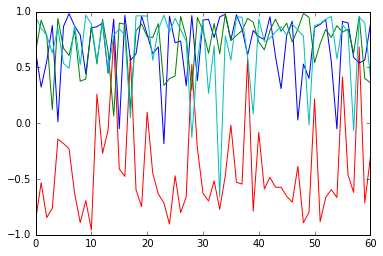

In [5]:
#Plots showing evolution of the correlations between some stocks
%matplotlib inline
a,b,c,d = [],[],[],[]
for i in range (0,61):
    a.append(daily_corr[i][9][94])
    b.append(daily_corr[i][97][95])
    c.append(daily_corr[i][10][11])
    d.append(daily_corr[i][10][12])
    

import matplotlib
import matplotlib.pyplot as plt
plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
plt.show()

In [6]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples):
    mu = np.zeros(100)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns

In [7]:
#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples):
    r0, r1 = return_generator(N_samples)
    model1 = []
    model2 = np.zeros((N_samples, 100, 100))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,10), range(0,10)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for (i,j) in product(range(0,100), range(0,100)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    


In [8]:
#Weights for standard minimum variance Markowitz portfolio
def weights(matrix, number_of_weights):
    a = np.linalg.inv(matrix)
    w = np.zeros(number_of_weights)
    c = 0
    for i in range (0, number_of_weights):
        for j in range (0, number_of_weights):
            w[i] += a[i][j]
        c += w[i]
    for i in range (0, number_of_weights):
        w[i] = w[i]/c
    return w

In [9]:
#Error function as variance of return of the optimal portfolio calculated from N_samples samples
#Depending on the weights of empirical models and diagonal model for correlation matrix
N_samples = 1000
m0, m1, r1 = empiric_models(N_samples)
m2 = np.identity(100)
def error(x):
    portfolio_returns = []
    for k in range (0, N_samples):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 100)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)

C:\Users\Mikhail\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: covariance is not positive-semidefinite.


In [10]:
#Determining optimal weights for the model by minimizing the error
from scipy import optimize
import datetime
x0 = [0.5, 0.3]
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
start_time = datetime.datetime.now()
res = optimize.minimize(error, x0, method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 10000})
print 'Time elapsed:', datetime.datetime.now() - start_time
print res
print res.x

Time elapsed: 0:07:31.450000
     fun: 0.034692198356196746
   maxcv: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 41
  status: 1
 success: True
       x: array([ 0.04115748,  0.95884252])
[ 0.04115748  0.95884252]


In [11]:
print error([0.19, 0.8])
print error([0.7, 0.25])
print error([0.8, 0.1])
print error([1.0, 0.0])
print error([0.0, 1.0])

0.0353471022027
0.0454635248954
0.0589894834817
932925.069229
0.0347232616325


In [12]:
print error(res.x)

0.0346921983562
